<img src="image/ub_pic.jpeg" style='width:100%;'>


# In this project we will create a prediction model to predict Ulaanbaatar housing price by per square meter

### Firstly, we should ask how this model can be used and how useful it is?
* We started this project to help house sellers and potential buyers to have a general square meter price estimation based on the khoroolol, surrounding places(schools and kindergartens), distance from city center and how safe the living area is. These features have significant impact on house prices even though some features like built year of the house, number of windows, direct sunlight have high impact. Our model is useful for anyone who is interested in house prices and the surrounding area information because there is no easy way to access all these information at once.   

### Important things to note here is that we have scraped 3863 rows from 2018-12-25 to 2019-02-25 data from __[Unegui.mn](https://www.unegui.mn/l-hdlh/l-hdlh-zarna/oron-suuts-zarna/)__ with features: date, title, rooms, price, location, and district  
* Datasets:
    * Main dataset unegui house dataset: house_prices.csv
    * Distance from city center obtained manually using google maps matching the locations from unegui: locations.csv
    * All locations' horoo and district matched manually using google maps and some locations have multiple khoroos and districts. Thus choosing only one khoroo and district will reduce the complexity of our feature: UneguiLocationsMapped.csv    
    * Number of schools & kindergartens each district: schools.csv, Kindergartens Ulaanbaatar.csv
    * Number of crimes per 100000 people calculated using khoroo_population dataset and crime_score dataset
* Objectives we will obtain through this project are: 
    * Try different predictive models with preprocessing 
    * Tune the best model's hyperparameters
    * Make __[ plotly dash](https://plot.ly/products/dash/)__ application 

In [1]:
import pandas as pd
import numpy as np
import re

import pickle
import json
import requests

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from skgarden import RandomForestQuantileRegressor

import xgboost
from sklearn.model_selection import RandomizedSearchCV

import dash
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Input, Output, State
import plotly.graph_objs as go


### First thing we need to do is import all the necessary datasets

In [2]:
df = pd.read_csv('data/house_prices.csv')
df.columns = df.columns.str.replace(' ', '')
df.district.value_counts()
dis_from_cc = pd.read_csv('data/locations.csv')
schools = pd.read_csv('data/schools.csv')
kindergartens = pd.read_csv('data/Kindergartens Ulaanbaatar.csv')
unegui_loc = pd.read_csv('data/UneguiLocationsMapped.csv')
crime_scores = pd.read_csv('data/crime_score.csv')
# Dropping districts from house_prices because they are not that accurate and we will use our mannually scraped location and khoroo data in order to add district and horoo
df = df.drop('district', axis=1)
unegui_loc['Khoroo1'] = pd.to_numeric(unegui_loc['Khoroo1'], downcast='integer')
df = df.merge(unegui_loc[['location', 'Khoroo1', 'district']], on='location', how='inner')

### Data cleaning
* find every nan or infinite values and remove them
* find outliers and remove them
* sqmtr outliers can be calculated by taking the 99th percentile and see values larger than this and it is reasonable to think that normal apartment maximum could be 500 sqmtr. Thus removing everything larger than 500. Not only removing larger values but we also need take care of smaller values which is 16sqmtr 1 room apartment and everything less than that should be removed
* convert date into valid format

In [3]:
pd.options.display.float_format = '{:.2f}'.format
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(axis=0, how='any', inplace=True)

niny_sqmtr = np.percentile(df['sqmtr'], 99)
print("First 5 largest sqmtr values \n",df[df['sqmtr'] > niny_sqmtr][['sqmtr', 'rooms']].sort_values(by='sqmtr', ascending=False).head())
print("First 5 smallest sqmtr values \n",df[df['sqmtr'] < 16][['sqmtr', 'rooms']].sort_values(by='sqmtr', ascending=False).head())

df = df[df['sqmtr'] < 560]
df = df[df['sqmtr'] > 10]

First 5 largest sqmtr values 
           sqmtr  rooms
3588 1700000.00      2
3742 1270000.00      3
3624  999999.00      2
41    145730.00      5
2539   11111.00      3
First 5 smallest sqmtr values 
       sqmtr  rooms
2730  12.00      1
2795  12.00      1
3323  10.00      4
2905   3.00      3
370    1.00      2


In [4]:
# remove last 5 characters (hh:mm) from date because we don't need hours and minuts
df['date'] = df['date'].astype(str).str[:-5]
# replace Өчигдөр (yesterday) with yesterdays date
df = df.replace('Өчигдөр', '2019-1-24')
df['date'] = pd.to_datetime(df['date'])
print(len(df))

2920


### Creating a new feature and our prediction target pricepermeter
* some price and pricepermeters are switched and fixing it
* humans make mistake and we guessed that when people inserting their place to unegui some of them put whole price and some of them put square meter price

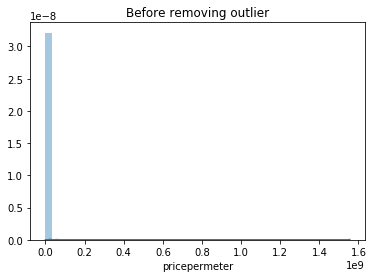

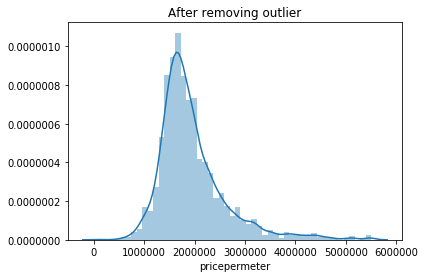

In [5]:
df['test'] = df['price']/df['sqmtr']
permtrprice = df[df['test']<=500000]
totalprice = df[df['test']>500000]

permtrprice = permtrprice.reset_index(drop=True)
totalprice = totalprice.reset_index(drop=True)

permtrprice['pricepermeter'] = permtrprice['price']
permtrprice['price'] = permtrprice['price']*permtrprice['sqmtr']
totalprice['pricepermeter'] = totalprice.test
totalprice.drop(columns='test', inplace=True)
permtrprice.drop(columns='test', inplace=True)
df = totalprice.append(permtrprice, ignore_index=True)


# pricepermeter before removing outlier
sns.distplot(df['pricepermeter'])
plt.title('Before removing outlier')
plt.show()

niny = np.percentile(df['pricepermeter'], 99)
df = df[df['pricepermeter'] <= niny]

# there are some values in between 5 million - 7 million but this is reasonable considering some luxurious places
sns.distplot(df['pricepermeter'])
plt.title('After removing outlier')
plt.show()

### Merging main dataframe with our additional feature: distance from city center, number of schools each district, number of kindergartens each district
* Removing a some districts which have less data in order to balance


In [6]:
# merging distance from city center
df = df.merge(dis_from_cc, on='location')

# dropping districts
df = df.drop(df[(df['district']=='Налайх') | 
                (df['district']=='Багахангай') | 
                (df['district']=='Багануур') | 
                (df['district']=='Орон нутаг')].index)
kindergartens = kindergartens.drop(kindergartens[(kindergartens['district']=='Налайх') | 
                (kindergartens['district']=='Багахангай') | 
                (kindergartens['district']=='Багануур') | 
                (kindergartens['district']=='Сонгинохайрхан') |
                (kindergartens['district']=='Орон нутаг')].index)

# merging number of schools and kindergartens on each district
n_schools = schools['district'].value_counts().tolist()
schools_district = pd.DataFrame({'n_schools':n_schools, 'district':['Сүхбаатар', 'Баянзүрх', 'Баянгол', 'Хан-Уул', 'Сонгинохайрхан', 'Чингэлтэй']})
df = pd.merge(df, schools_district, on='district')

n_kindergartens = kindergartens['district'].value_counts().tolist()
kindergarten_district = pd.DataFrame({'n_kindergartens':n_kindergartens, 'district':['Баянзүрх', 'Баянгол', 'Хан-Уул', 'Сүхбаатар', 'Чингэлтэй']})
df = pd.merge(df, kindergarten_district, on='district')


### Creating another feature called dis_horoo combination of district + horoo e.g: Чингэлтэй, 1
* create for our main df first and then crime_scores df
* this feature is later used to merge crime scores for each District horoos

In [7]:
df['Khoroo1'] = pd.to_numeric(df['Khoroo1'], errors='coerce', downcast='integer')
df = df.dropna()
df = df.reset_index(drop=True)
df_dis = df['district']
df_horoo = df['Khoroo1']
df_dis_horoo = []
for i in range(len(df_dis)):
    hor = df_horoo[i]
    hor = int(hor)
    hee = df_dis[i]+", " + str(hor)
    df_dis_horoo.append(hee)
df['dis_horoo'] = df_dis_horoo
df = df.drop_duplicates()

In [8]:
# creating dis_horoo in crimes_score df
crime_scores['district_khoroo']
dada = [i.split() for i in crime_scores['district_khoroo']]
dis = [i[0] for i in dada]
hor = [i[1] for i in dada]
hor = [i.split('-') for i in hor]
hor = [i[0] for i in hor]
dis_horoo_crime = []
for i in range(len(dis)):
    district = dis[i]
    horoo = hor[i]
    dis_horoo = district+', '+str(horoo)
    dis_horoo_crime.append(dis_horoo)
crime_scores['dis_horoo'] = dis_horoo_crime
# merging main df with crime_scores df on dis_horoo
df = df.merge(crime_scores[['score_2016', 'dis_horoo']], on='dis_horoo')

We can see some correlations from the heatmap such as price and rooms, price and sqmtr, number of kindergartens and schools while majority of the variables have very low correlation

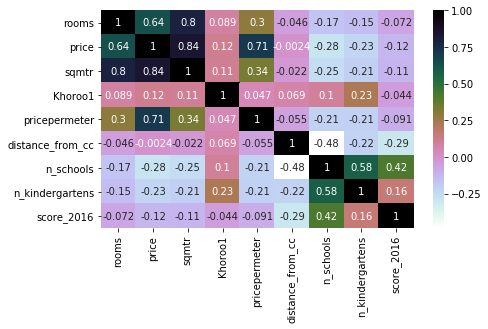

In [9]:
plt.figure(figsize=(7,4)) 
sns.heatmap(df.corr(),annot=True,cmap='cubehelix_r') 
plt.show()

### Now we need to prepare our data for train and test split


In [10]:
# getting numerical features and target
X = df[['rooms','sqmtr', 'distance_from_cc', 'n_schools', 'n_kindergartens', 'score_2016']]
y = df['pricepermeter']
# after cleaning and dropping values only 40 locations are available out of 77 locations this will be used later
all_locs = df.groupby('location')['date'].count().reset_index()
all_locs = all_locs['location'].tolist()
print(all_locs)


['10-р хороолол', '100 айл', '11-р хороолол', '120 мянгат', '13-р хороолол', '14-р хороолол', '15-р хороолол', '16-р хороолол', '19-р хороолол', '220 мянгат', '5-р хороолол', '6-р бичил', 'Japan town', 'King Tower', 'Marshall town', 'Olympic village', 'River Garden', 'UB Town', 'Zaisan luxury village', 'Амгалан', 'Бага тойрог', 'Баянбүрд', 'Баянмонгол хороолол', 'Зайсан', 'Зурагт', 'Зүүн 4 зам', 'Их Монгол хороолол', 'Нисэх', 'Нэхмэлийн шар', 'Оддын хороолол', 'Сансар', 'Тээврийн товчоо', 'Төмөр зам', 'Улиастай', 'Ханбүргэдэй', 'Хос-Өргөө', 'Чингэлтэй', 'Шар хад', 'Эрдэнэ толгой', 'Яармаг']


In [11]:
# getting categorical features and one hot encoding it and combining it with numerical features
dummy_fs = pd.get_dummies(df[['location', 'district','dis_horoo']])
X = pd.concat([X, dummy_fs], axis=1)


In [12]:
# train and test split with 30% test and 70% training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.3, random_state= 1234)

### First model we will try is Linear Regression
* Linear Regression is used to study and summarize the relationship between multiple quantitative variables and of course it is a common and well performing predictive model

In [13]:
linreg = LinearRegression() #instantiate the model
linreg.fit(X_train, y_train) # fit the model with training datasets
y_pred_lin = linreg.predict(X_test) # make a prediction on the test dataset

Mean Absolute Error: 345741.33
Root Mean Squared Error 502861.57236786105
R^2:  0.39596057846198507
Accuracy: 82.61 %.


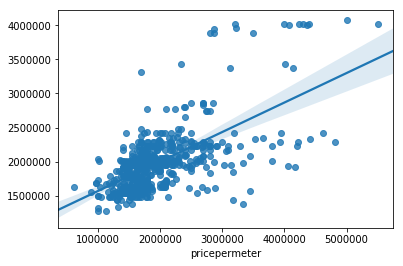

In [14]:
# Model evaluation
errors = abs(y_pred_lin - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))
#mean absolute percentage error
mape = 100*(errors / y_test)
accuracy = 100 - np.mean(mape)
#RMSE has the benefit of penalizing large errors more
print('Root Mean Squared Error',np.sqrt(metrics.mean_squared_error(y_test, y_pred_lin)))
print('R^2: ', linreg.score(X_test, y_test))
print('Accuracy:', round(accuracy, 2), '%.')
sns.regplot(y_test, y_pred_lin)
plt.show()

### Second model we will try is Random Forest Regressor
* Random Forest Regressor operates by constructing a multiple decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees

In [15]:
rfreg = RandomForestRegressor(n_estimators=1000)
rfreg.fit(X_train, y_train)
y_pred_rfreg = rfreg.predict(X_test)


Mean Absolute Error: 317080.79
Root Mean Squared Error 469927.7088767299
R^2:  0.4724902488189566
Accuracy: 83.57 %.


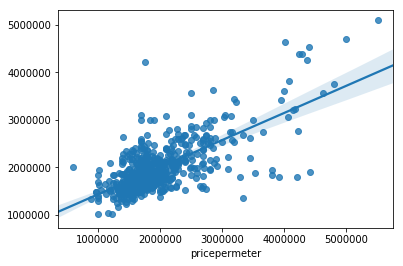

In [16]:
# Model evaluation
errors = abs(y_pred_rfreg - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))
#mean absolute percentage error
mape = 100*(errors / y_test)
accuracy = 100 - np.mean(mape)
#RMSE has the benefit of penalizing large errors more
print('Root Mean Squared Error',np.sqrt(metrics.mean_squared_error(y_test, y_pred_rfreg)))
print('R^2: ', rfreg.score(X_test, y_test))
print('Accuracy:', round(accuracy, 2), '%.')
sns.regplot(y_test, y_pred_rfreg)
plt.show()

### Third model we will try is Xgboost
* Xgboost is short for eXtreme gradient boosting, a better vesion of decision trees and is focused on computational speed and performance

In [17]:
xgb = xgboost.XGBRegressor()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

Mean Absolute Error: 295141.3
Root Mean Squared Error 426560.9465360582
R^2:  0.5653591234981986
Accuracy: 84.61 %.


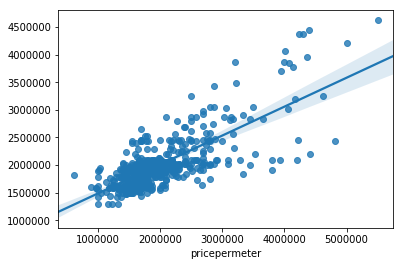

In [18]:
# Model evaluation
errors = abs(xgb_pred - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))
#mean absolute percentage error
mape = 100*(errors / y_test)
accuracy = 100 - np.mean(mape)
#RMSE has the benefit of penalizing large errors more
print('Root Mean Squared Error',np.sqrt(metrics.mean_squared_error(y_test, xgb_pred)))
print('R^2: ', xgb.score(X_test, y_test))
print('Accuracy:', round(accuracy, 2), '%.')
sns.regplot(y_test, xgb_pred)
plt.show()

### Model evaluation 
* Mean Absolute Error means how far residuals are from actual data points in absolute number meaning no negative.
* Root Mean Squared Error tells us how spread our residuals are from the best fitted line
* R squared tells us what percentage of our target variable can be explained by the other variables
* Accuracy tells us how close we are to the true value
* Above two model results are really different from others. Mean absolute error and root mean squared errors have some 30000 price difference even though the r-squared and the accuracy are almost same.
* The best performing model on the 3 models is XgboostRegressor and even though the high r-squared, and accuracy none of the models can give us the output we wanted directly in our hand.


## Our main goal of the project is to give people a price range that lies between 25th and 75th prediction interval and the most suitable model for this goal is Random Forest Quantile Regressor
### We will be using Random Forest Quantile Regressor and tuning its hyperparamters using RandomizedSearchCV since GridSearchCV will be computationally expensive
* this takes 15-25 minutes and end of it gives us the best parameters to use in our model
* uncomment the cell below to run the cell and see the estimation process if you want. I have done it already and the best estimators will be used in the next cell. 

In [21]:
# rfqr = RandomForestQuantileRegressor()
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}
# rfqr_random = RandomizedSearchCV(estimator = rfqr, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# rfqr_random.fit(X_train, y_train)
# print(rfqr_random.best_estimator_)

In [13]:
# instantiating rfqr with the best parameters
rfqr = RandomForestQuantileRegressor(bootstrap=True, criterion='mse', max_depth=10,
               max_features='sqrt', max_leaf_nodes=None,
               min_samples_leaf=1, min_samples_split=5,
               min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
               oob_score=False, random_state=2345, verbose=0,
               warm_start=False)
rfqr.fit(X_train, y_train)

RandomForestQuantileRegressor(bootstrap=True, criterion='mse', max_depth=10,
               max_features='sqrt', max_leaf_nodes=None,
               min_samples_leaf=1, min_samples_split=5,
               min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=1,
               oob_score=False, random_state=2345, verbose=0,
               warm_start=False)

Now we need to predict the upper, mid and lower intervals because when we are predicting a price square meter it is preferable to give 25th percentiles to 75th percentile prediction interval rather than giving out 2.5th percentile to 97.5th percentile. By giving out such low range has an advantage of reducing high variance. 

In [14]:
upper_pre_int = rfqr.predict(X_test, quantile=75)
mid_pre_int = rfqr.predict(X_test, quantile=50)
lower_pre_int = rfqr.predict(X_test, quantile=25)


Mean Absolute Error: 299214.4
Mean squared error 205852700741.7145
ROOT Mean squared error 453709.9301775469
R^2:  0.5120876521972458
Accuracy: 85.2 %.


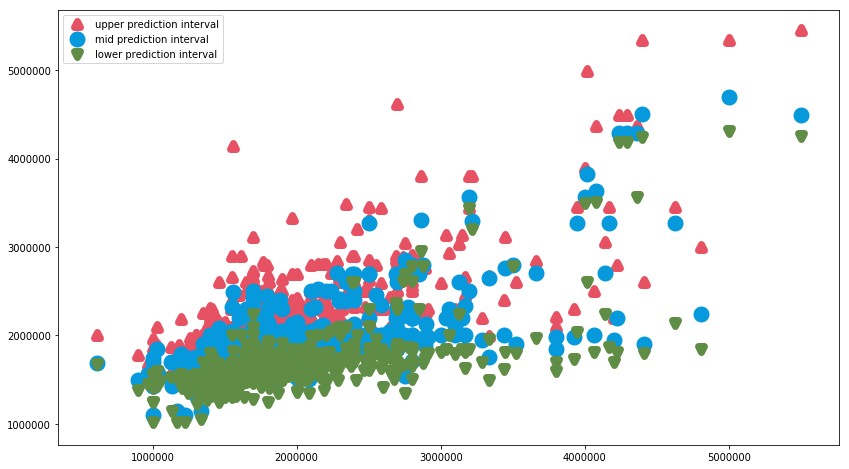

In [15]:
errors = abs(mid_pre_int - y_test)
print('Mean Absolute Error:', round(np.mean(errors), 2))
#mean absolute percentage error
mape = 100*(errors / y_test)
accuracy = 100 - np.mean(mape)
print('Mean squared error',metrics.mean_squared_error(y_test, mid_pre_int))
print('ROOT Mean squared error',np.sqrt(metrics.mean_squared_error(y_test, mid_pre_int)))
#RMSE has the benefit of penalizing large errors more
print('R^2: ', rfqr.score(X_test, y_test))
print('Accuracy:', round(accuracy, 2), '%.')
plt.figure(figsize=(14, 8))

plt.scatter(y_test, upper_pre_int, color='#E65263', marker="^",linewidths='7')
plt.scatter(y_test, mid_pre_int, color='#069ADC', marker='o',linewidths='10')
plt.scatter(y_test, lower_pre_int, color='#608D45', marker="v",linewidths='7')
plt.legend(('upper prediction interval', 'mid prediction interval', 'lower prediction interval'))

plt.show()

### Final Model Evaluation
* R squared and accuracy is both relatively higher than the previous models and the output is what we wanted(25th percentile and 75th percentile)
* Observing the graph we can see that there is clear linear trend and red triangle is the upper prediction interval, blue dot is the mid interval, and green triangles are lower prediction interval.

### Export model
* export model using pickle and deploying on the remote server which will be heroku

In [35]:
# pickle.dump(rfqr, open("ub_house_price_model.pkl","wb"))
my_model = pickle.load(open('ub_house_price_model.pkl','rb'))
# my_model.predict(X_test[0:1], 50)

array([1571428.625])

### Using plotly dash to make it into a production


In [20]:
# Save dataframe as a csv for the later usage for all location
dash_pred_input = pd.DataFrame(columns=['location','district','dis_horoo','rooms','sqmtr','distance_from_cc', 'n_schools','n_kindergartens','crime_score'])
for i in range(len(all_locs)):
    dd = df[df['location']==all_locs[i]][['location', 'district','dis_horoo','distance_from_cc','n_schools','n_kindergartens','score_2016']].iloc[0]
    dash_pred_input = dash_pred_input.append({'location': dd['location'], 
                                              'district': dd['district'], 
                                              'dis_horoo': dd['dis_horoo'],
                                              'distance_from_cc':dd['distance_from_cc'],
                                              'n_schools':dd['n_schools'],
                                              'n_kindergartens':dd['n_kindergartens'],
                                              'crime_score':dd['score_2016']
                                             }, ignore_index=True)
    
dash_pred_input.head()
# finding location of user input
dash_pred_input.to_csv('dash_pred_input.csv', sep=',')

In [54]:
### STARTING DASH APP
app = dash.Dash()
# getting all the available locations as options in a dashboard dropdown
dash_pred_input = pd.read_csv('dash_pred_input.csv', index_col=0)
dash_dummies_cat_features = pd.get_dummies(dash_pred_input[['location','district','dis_horoo']])
dash_numerical_features = dash_pred_input.drop(['location','district','dis_horoo'], axis=1)
dash_numerical_features['rooms']=1

all_locs = ['10-р хороолол', '100 айл', '11-р хороолол', '120 мянгат', '13-р хороолол', '14-р хороолол', '15-р хороолол', '16-р хороолол', '19-р хороолол', '220 мянгат', '5-р хороолол', '6-р бичил', 'Japan town', 'King Tower', 'Marshall town', 'Olympic village', 'River Garden', 'UB Town', 'Zaisan luxury village', 'Амгалан', 'Бага тойрог', 'Баянбүрд', 'Баянмонгол хороолол', 'Зайсан', 'Зурагт', 'Зүүн 4 зам', 'Их Монгол хороолол', 'Нисэх', 'Нэхмэлийн шар', 'Оддын хороолол', 'Сансар', 'Тээврийн товчоо', 'Төмөр зам', 'Улиастай', 'Ханбүргэдэй', 'Хос-Өргөө', 'Чингэлтэй', 'Шар хад', 'Эрдэнэ толгой', 'Яармаг']

dash_locs_options = [{"label":i, "value":i} for i in all_locs]

print(dash_pred_input.head())

        location   district      dis_horoo  rooms  sqmtr  distance_from_cc  \
0  10-р хороолол    Баянгол     Баянгол, 4    nan    nan              4.40   
1        100 айл  Сүхбаатар  Сүхбаатар, 11    nan    nan              2.60   
2  11-р хороолол  Сүхбаатар   Сүхбаатар, 7    nan    nan              1.50   
3     120 мянгат    Хан-Уул     Хан-Уул, 1    nan    nan              2.40   
4  13-р хороолол   Баянзүрх    Баянзүрх, 6    nan    nan              2.10   

   n_schools  n_kindergartens  crime_score  
0         19               68      1134.33  
1         22               57      2152.59  
2         22               57      1986.91  
3         17               62      1037.26  
4         21              105      1284.34  


### STARTING DASH APP LAYOUT consists of
* input location
* input number of rooms
* square meters

In [55]:
app.css.append_css({'external_url':'https://use.fontawesome.com/releases/v5.7.2/css/all.css'})
import base64
image_filename = 'image/ub_pic.jpeg' # replace with your own image
encoded_image = base64.b64encode(open(image_filename, 'rb').read())
myimg = 'data:image/jpeg;base64,{}'.format(encoded_image.decode())

app.layout = html.Div([
    html.Img(src=myimg, height='200px',width='100%'),
    html.Div([
    html.Div([
        dcc.Dropdown(
        id='av_locs',
        options=dash_locs_options,
        placeholder='Choose ur location'
        ),
        html.Div([
            html.Label('Number of rooms', style={'display':'block', 'float':'left', 'height':'30px','line-height':'30px', 'padding':'1% 0', 'font-size':'16px', 'font-family':'serif'}),
            dcc.Input(
                id='num_rooms',
                type='number', 
                inputmode='numeric', 
                max=10, 
                min=0,
                placeholder='Number of rooms',
                style={'display':'block', 'float':'right', 'height':'30px','line-height':'30px', 'width':'25%', 'border-radius':'12px','text-align':'center'}
            )
        ], style={'height':'40px', 'padding':'0 5px', 'background':'#91f5a4'}),
        html.Div([
            html.Label('Number of square meter', style={'display':'block', 'float':'left', 'height':'30px','line-height':'30px', 'padding':'1% 0', 'font-size':'16px', 'font-family':'serif'}),
            dcc.Input(
                id='sqmtr',
                type='number', 
                inputmode='numeric', 
                max=600, 
                min=0,
                placeholder='Choose your place size in square meter',
                style={'display':'block', 'float':'right', 'height':'30px','line-height':'30px', 'width':'25%', 'border-radius':'12px','text-align':'center'}
            )
        ], style={'height':'40px', 'padding':'0 5px', 'background':'#91f5a4'}),
        html.Button(id='predict_button', type='submit', children='Predict', style={'width':'100%', 
                                                                                   'height':'30px', 
                                                                                   'display':'block',
                                                                                   'border-radius':'0 0 9px 9px',
                                                                                   'font-size':'16px',
                                                                                  'font-family':'serif'}),
        html.Div([
            html.H3(children='Predictions are made on all locations using the user input'),
            html.Ul([
                html.Li(children='Large screen devices are recommended to see the outputs',style={"padding":'6px'}),
                html.Li(children='You are able to compare prices of different places',style={"padding":'6px'}),
                html.Li(children='Additionally appartment prices may depend on the surrounding places such as: number of kindergartens, schools, crimes per 100 thousand people, and distance from city center',style={"padding":'6px'}),
                html.Li(children="A few core determinents such as age of the appartment and side it faces are not used in the model thus can't be displayed",style={"padding":'6px'}),
                html.Li(children="Main dataset(3863 rows, 2018-12-25:2019-02-25) has been scrapped from 'Unegui.mn' for educational purpose",style={"padding":'6px'}),
                html.Li(children="Resources and work here: https://github.com/robertritz/mongol.ai/tree/W_branch")
            ]),
        ], style={"border":"1px solid red", 'border-radius':'10px','padding':'10px'}),
        
        
    ], style={'float':'left', 'width':'450px'}),
    html.Div([],id="dash_prediction_output", style={'display':'grid', 
                                              'grid-template-columns':'1fr 1fr', 
                                              'grid-template-areas':'"first_con second_con""third_con third_con"'}),
    ], style={'display':'grid','grid-template-columns': '1fr 2fr'}),

    html.Div(id='output')
])

In [56]:
@app.callback(Output('dash_prediction_output', 'children'),
             [Input('predict_button', 'n_clicks')],
             [State('av_locs', 'value'),
              State('num_rooms', 'value'),
              State('sqmtr', 'value')])

def get_inputs(submit, av_locs, num_rooms, sqmtr):
    if submit is not None:
        # use input for every location
        dash_numerical_features['rooms']= num_rooms
        dash_numerical_features['sqmtr']= sqmtr
        
        # finding location of user input
        user_input_loc_in_preds = dash_pred_input[dash_pred_input['location']==av_locs].index[0]
        #additional info for user input
        add_n_schools = dash_pred_input[dash_pred_input['location']==av_locs]['n_schools'].get_values()[0]
        add_n_kindergts = dash_pred_input[dash_pred_input['location']==av_locs]['n_kindergartens'].get_values()[0]
        add_distance_from_cc = dash_pred_input[dash_pred_input['location']==av_locs]['distance_from_cc'].get_values()[0]
        add_crime_score = dash_pred_input[dash_pred_input['location']==av_locs]['crime_score'].get_values()[0]
        avg_crimes_per_h1000s = dash_pred_input['crime_score'].mean()
        
        # now we need to concat numerical features with categorical(one hot encoded) features 
        deployment_input = pd.concat([dash_numerical_features, dash_dummies_cat_features], axis=1)

        upper_int = my_model.predict(deployment_input, quantile=75)
        upper_int_main_pred = upper_int[user_input_loc_in_preds]
        
        mid_int = my_model.predict(deployment_input, quantile=50)
        mid_int_main_pred = mid_int[user_input_loc_in_preds]
        
        lower_int = my_model.predict(deployment_input, quantile=25)
        lower_int_main_pred = lower_int[user_input_loc_in_preds]
        
        ### Output htmls
        prediction_interval_html = html.Div([
                    html.Div([
                        html.P('Max price'),
                        html.Div(children='₮ {}'.format(comma_me(str(round(upper_int_main_pred)))),
                            style={
                              'background':'#ff4e4e',
                              'padding': '5px 10px',
                              'border-radius': '10px',
                              'color': 'whitesmoke',
                              'margin': '10px auto'
                            }
                        )
                    ], style={'display':'grid','grid-template-columns': '1fr 1fr'}),
                    html.Div([
                        html.P('Mid price'),
                        html.Div(children='₮ {}'.format(comma_me(str(round(mid_int_main_pred)))),
                            style={
                              'background':'#9ee3e9',
                              'padding': '5px 10px',
                              'border-radius': '10px',
                              'color': 'whitesmoke',
                              'margin': '10px auto'
                            }
                        )
                    ], style={'display':'grid','grid-template-columns': '1fr 1fr'}),
                    html.Div([
                        html.P('Min price'),
                        html.Div(children='₮ {}'.format(comma_me(str(round(lower_int_main_pred)))),
                            style={
                              'background':'#3dff6f',
                              'padding': '5px 10px',
                              'border-radius': '10px',
                              'color': 'whitesmoke',
                              'margin': '10px auto'
                              }
                        )
                    ], style={'display':'grid','grid-template-columns': '1fr 1fr'}),
        ], style={"float":'left', 'padding':'0 10%', 'grid-area':'first_con', 'display':'block', 'border':'1px solid red', 'border-radius':'10px'})
        
        additional_info_html = html.Div([
            html.Div([
                html.Div(children=add_n_kindergts,style={'text-align':'center', 'font-size':'25px', 'margin':'auto 0'}),
                html.Div([
                    html.I(className='fas fa-baby', title='Kindergartens', style={'font-size':'30px'}),
                    html.Plaintext('kindergartens')
                ], style={'text-align':'right'})
            ], style={
                'background':'rgb(145, 245, 164)',
                'font-size':'18px',
                'padding':'10px',
                'border-radius':'14px',
                'display':'grid',
                'grid-template-columns':'1fr 1fr',
                'height':'65px'
                }),
            html.Div([
                html.Div(children=add_n_schools,style={'text-align':'center', 'font-size':'25px', 'margin':'auto 0'}),
                html.Div([
                    html.I(className='fas fa-school', title='schools', style={'font-size':'30px'}),
                    html.Plaintext('schools')
                ], style={'text-align':'right'})
            ], style={
                'background':'rgb(218, 251, 0)',
                'font-size':'18px',
                'padding':'10px',
                'border-radius':'14px',
                'display':'grid',
                'grid-template-columns':'1fr 1fr',
                'height':'65px'
                }),
            html.Div([
                html.Div(children='{} vs avg {}'.format(round(add_crime_score,0), round(avg_crimes_per_h1000s)),style={}),
                html.I(className='fas fa-fist-raised', title='crime', style={'font-size':'30px'}),
                html.Div([
                    html.Plaintext('crimes per 100,000 ')
                ], style={'text-align':'right'})
            ], style={
                'background':'rgb(245, 55, 95)',
                'font-size':'18px',
                'padding':'10px',
                'border-radius':'14px',
                'display':'grid',
                'grid-template-columns':'1fr 1fr',
                'height':'70%'
                }),
            html.Div([
                html.Div(children='{} km'.format(add_distance_from_cc), style={'text-align':'center', 'font-size':'25px'}),
                html.I(className='fas fa-map-marked-alt', title='dfcc', style={'font-size':'30px'}),
                html.Div([
                    html.Plaintext('from city center')
                ], style={'text-align':'right'})
            ], style={
                'background':'rgb(145, 245, 234)',
                'font-size':'18px',
                'padding':'10px',
                'border-radius':'14px',
                'display':'grid',
                'grid-template-columns':'1fr 1fr',
                'height':'70%'
                })
        ], style={'grid-area':'second_con', 'display':'grid','grid-template-columns':'1fr 1fr'})
        my_colors = []
        for i in range(len(dash_pred_input)):
            if dash_pred_input['location'][i] == dash_pred_input['location'][user_input_loc_in_preds]:
                my_colors.append('rgb(245, 55, 95)')
            else:
                my_colors.append('rgb(7, 119, 106)')
        
        all_locs_graph = html.Div([
            dcc.Graph(
               figure = {
                    'data':[go.Bar(
                        y=mid_int, 
                        x=dash_pred_input['location'],
                        marker={'color':my_colors}
#                         orientation='h'
                    )],
                   'layout': go.Layout(
                       autosize=True,
                       title='Prediction on all locations',
                       yaxis={'ticklen':10}
                   )
                } 
            )
        ], style={'grid-area':'third_con'})
        
        
        return prediction_interval_html, additional_info_html, all_locs_graph

def comma_me(amount):
    orig = amount
    new = re.sub("^(-?\d+)(\d{3})", '\g<1>,\g<2>', amount)
    if orig == new:
        return new
    else:
        return comma_me(new)

In [57]:
if __name__ == '__main__':
    app.run_server()

 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [17/Apr/2019 22:18:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [17/Apr/2019 22:18:55] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [17/Apr/2019 22:18:55] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [17/Apr/2019 22:18:55] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [17/Apr/2019 22:19:02] "POST /_dash-update-component HTTP/1.1" 200 -


## Fully deployed web app looks like below

<img src="image/dash_pic.png">